# Simple sequential model
*   Data - Random Numbers
*   Framework - Tensorflow 2.2

The notebook demonstrates how to create a very basic sequential model with random data.
The data generated has the following characteristics


1.   Seasonality
2.   Trend
3.   Noise

The method implemeted also showcases the use of **shuffled**, **windowed** batches for training the model.



In [5]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [7]:
def plot_series(time, series, format="-", start=0, end=None):
  """For plotting a simple time series"""
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

### Functions for generating random time series data

In [8]:
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [9]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """Function for creating a windowed dataset for sequence training"""
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [11]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.03988675],
       [-0.00323222],
       [ 0.06002869],
       [-0.0166163 ],
       [ 0.02563589],
       [-0.07516331],
       [ 0.02909337],
       [ 0.05713112],
       [ 0.01092809],
       [-0.05716983],
       [ 0.0261558 ],
       [ 0.04305252],
       [-0.07710604],
       [-0.03045473],
       [ 0.0784674 ],
       [ 0.08582939],
       [ 0.08352796],
       [ 0.08439976],
       [ 0.2335874 ],
       [ 0.50281924]], dtype=float32), array([0.01555086], dtype=float32)]


In [12]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

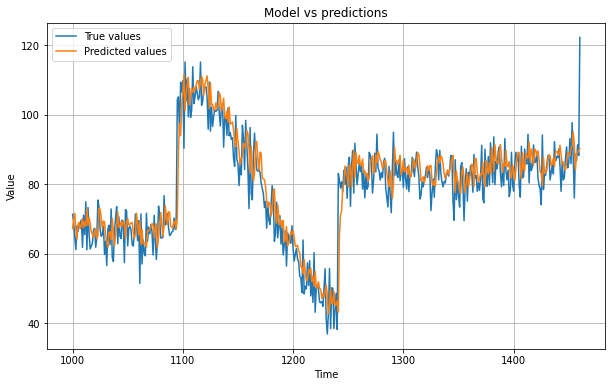

In [15]:
plt.figure(figsize=(10, 6))
plt.title('Model vs predictions')

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

plt.legend(["True values", "Predicted values"])
plt.show()

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.281024